In [2]:
import CairoMakie
import Makie
using Images: Gray
using Images: gray
using MLDatasets: MNIST
using MosaicViews: mosaicview
using Optimisers: Adam
using ProgressMeter: @showprogress
using Random: bitrand
using RestrictedBoltzmannMachines: Binary
using RestrictedBoltzmannMachines: free_energy
using RestrictedBoltzmannMachines: initialize!
using RestrictedBoltzmannMachines: mean_from_inputs
using RestrictedBoltzmannMachines: pcd!
using RestrictedBoltzmannMachines: RBM
using RestrictedBoltzmannMachines: sample_from_inputs
using RestrictedBoltzmannMachines: sample_h_from_v
using RestrictedBoltzmannMachines: sample_v_from_v
using RestrictedBoltzmannMachines: xReLU
using RestrictedBoltzmannMachines: standardize
using Statistics: cor
using Statistics: cov
using Statistics: mean
using Statistics: std
using Statistics: var

In [3]:
train_x = MNIST(split=:train).features .> 0.5
train_y = MNIST(split=:train).targets;
tests_x = MNIST(split=:test).features .> 0.5
tests_y = MNIST(split=:test).targets;

In [5]:
rbm = RBM(Binary((28,28)), xReLU((300,)), randn(28,28,300))
initialize!(rbm, train_x);
rbm = standardize(rbm);

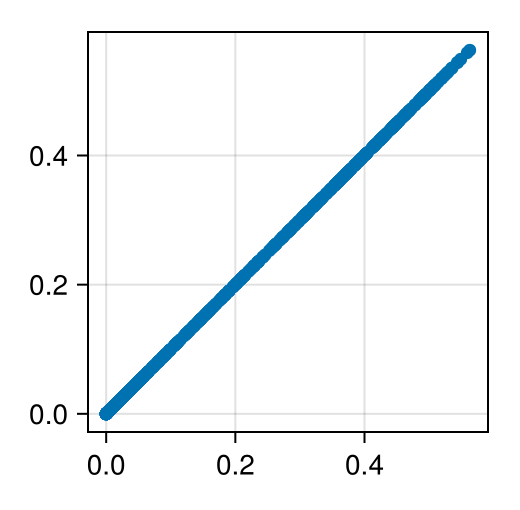

In [6]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=200, height=200)
Makie.scatter!(ax, vec(mean(train_x; dims=3)), vec(mean_from_inputs(rbm.visible, zeros(28, 28))))
Makie.resize_to_layout!(fig)
fig

In [7]:
grad_history = []
function callback(; rbm, optim, iter, vm, vd, ∂, _...)
    if iszero(iter % 10)
        push!(grad_history, ∂) # collecting gradient for some tests ... not needed
    end
end

optim = Adam(1f-4, (0f0, 999f-3), 1f-6)
batchsize = 256
vm = sample_from_inputs(rbm.visible, zeros(28, 28, batchsize))
vm = bitrand(28, 28, batchsize)
training_time = @elapsed begin
    state, ps = pcd!(
        rbm, train_x;
        optim, steps=50, batchsize, iters=50000, vm, l2l1_weights=0.001, # same as RBMs.jl
        ϵv=1f-1, ϵh=0f0, damping=1f-1, # parameters controlling the hidden unit statistics normalization
        callback
    )
end

InterruptException: InterruptException:

In [8]:
mean(sample_h_from_v(rbm, gpu(train_x)); dims=2) |> extrema

(-0.5651474f0, 0.55438185f0)

In [9]:
std(sample_h_from_v(rbm, gpu(train_x)); dims=2) |> extrema

(0.9746501f0, 1.0409923f0)

In [12]:
mean(sample_h_from_v(rbm, vm); dims=2) |> extrema

(-0.63594556f0, 0.5778683f0)

In [13]:
std(sample_h_from_v(rbm, vm); dims=2) |> extrema

(0.8616021f0, 1.1475817f0)

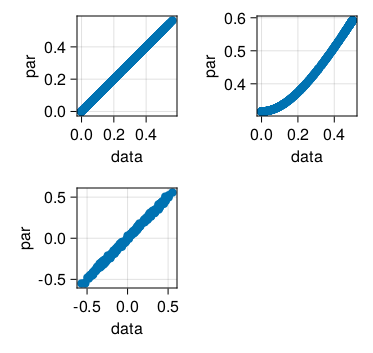

In [14]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=100, height=100, xlabel="data", ylabel="par")
Makie.scatter!(ax, vec(mean(train_x; dims=3)), vec(cpu(rbm.offset_v)))
ax = Makie.Axis(fig[1,2], width=100, height=100, xlabel="data", ylabel="par")
Makie.scatter!(ax, vec(std(train_x; dims=3)), vec(cpu(rbm.scale_v)))
ax = Makie.Axis(fig[2,1], width=100, height=100, xlabel="data", ylabel="par")
Makie.scatter!(ax, vec(mean(sample_h_from_v(rbm, train_x); dims=2)), vec(cpu(rbm.offset_h)))
Makie.resize_to_layout!(fig)
fig

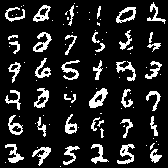

In [15]:
mosaicview(Gray.(cpu(vm)[.., 1:36]), nrow=6)'

In [16]:
#sampled_v = cpu(sample_v_from_v(rbm, gpu(tests_x); steps=500));
#sampled_v = sample_from_inputs(rbm.visible, gpu(zeros(28, 28, 5000)));
sampled_v = gpu(bitrand(28, 28, 5000));
sampled_f = zeros(1000)
@showprogress for t in 1:length(sampled_f)
    sampled_v .= sample_v_from_v(rbm, sampled_v; steps=100)
    sampled_f[t] = mean(free_energy(rbm, sampled_v))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:37


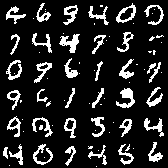

In [26]:
mosaicview(Gray.(cpu(sampled_v)[.., rand(1:size(sampled_v,3), 36)]), nrow=6)'

In [27]:
mean(sample_h_from_v(rbm, gpu(sampled_v)); dims=2) |> extrema

(-0.6347595f0, 0.93403f0)

In [28]:
std(sample_h_from_v(rbm, gpu(sampled_v)); dims=2) |> extrema

(0.7692292f0, 1.4582152f0)

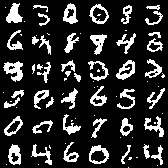

In [30]:
mosaicview(Gray.(sampled_v[.., 1:36]), nrow=6)'

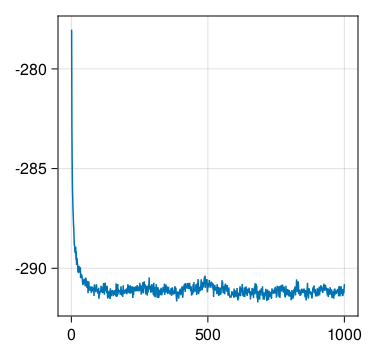

In [19]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.lines!(ax, sampled_f)
Makie.resize_to_layout!(fig)
fig

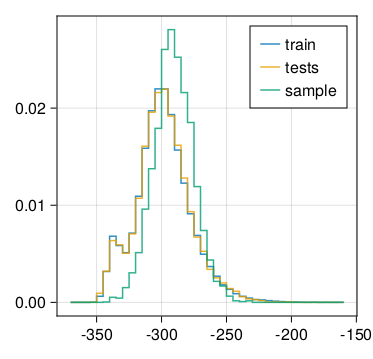

In [20]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.stephist!(ax, free_energy(rbm, train_x), bins=-370:5:-160, label="train", normalization=:pdf)
Makie.stephist!(ax, free_energy(rbm, tests_x), bins=-370:5:-160, label="tests", normalization=:pdf)
Makie.stephist!(ax, cpu(free_energy(rbm, sampled_v)), bins=-370:5:-160, label="sample", normalization=:pdf)
Makie.axislegend(ax, position=:rt)
Makie.resize_to_layout!(fig)
fig

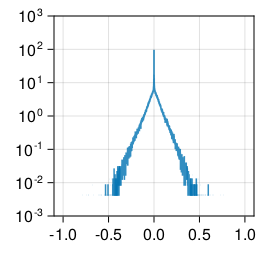

In [21]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=200, height=200, yscale=log10)
Makie.stephist!(ax, vec(rbm.w), bins=-1:0.001:1, fillto=1e-6, normalization=:pdf)
Makie.ylims!(ax, 1e-3, 1e3)
Makie.resize_to_layout!(fig)
fig

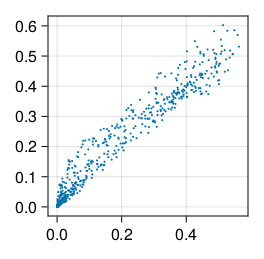

In [22]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=200, height=200)
Makie.scatter!(ax,
    vec(mean(train_x; dims=3)),
    vec(cpu(mean(sampled_v; dims=3))),
    markersize=3
)
Makie.resize_to_layout!(fig)
fig

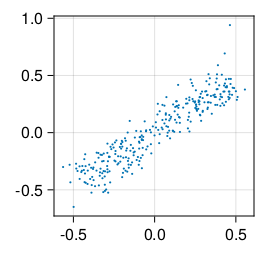

In [23]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=200, height=200)
Makie.scatter!(ax,
    cpu(vec(mean(sample_h_from_v(rbm, gpu(train_x)); dims=2))),
    cpu(vec(mean(sample_h_from_v(rbm, sampled_v); dims=2))),
    markersize=3
)
Makie.resize_to_layout!(fig)
fig

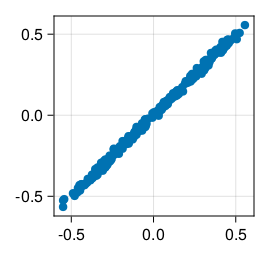

In [29]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=200, height=200)
Makie.scatter!(ax,
    vec(rbm.offset_h),
    cpu(vec(mean(sample_h_from_v(rbm, gpu(train_x)); dims=2)))
)
Makie.resize_to_layout!(fig)
fig

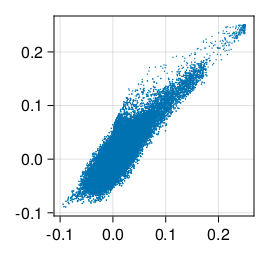

In [25]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=200, height=200)
Makie.scatter!(ax,
    vec(cov(reshape(tests_x, 28*28, :); dims=2)),
    vec(cov(reshape(cpu(sampled_v), 28*28, :); dims=2)),
    markersize=2
)
Makie.resize_to_layout!(fig)
fig